In [5]:
%matplotlib inline
import torch
from d2l import torch as d2l
import math
#精简打印精度
torch.set_printoptions(2)

In [6]:
#生成以每个像素为中心具有不同形状的锚框
def multibox_prior(data,sizes,ratios):
    """
    size:锚框占整个图像的比例，取值(0,1]
    ratio:原图像的宽高比的放缩比
    """

    #每个图像的tensor有四个维度前两个是batch_size和通道，所以取后两个来确定高宽
    in_height,in_width=data.shape[-2:]
    #获取size和ratio的个数从而确定能够生成多少个锚框
    device,num_sizes,num_ratios=data.device,len(sizes),len(ratios)
    #每个像素的锚框的数量
    boxes_per_pixel=(num_sizes+num_ratios-1)
    
    #将size和ratios转换成tensor格式
    size_tensor=torch.tensor(sizes,device=device)
    ratio_tensor=torch.tensor(ratios,device=device)

    #为了将锚点移动到像素的中心，需要设置偏移量
    #因为一个像素的高宽为1所以选择偏移我们的中心0.5
    offset_h,offset_w=0.5,0.5
    steps_h=1.0/in_height#y轴上缩放步长
    steps_w=1.0/in_width#x轴上缩放步长

    #生成锚框的所有中心点,中心点被集中在(0,1)的这样一个小方形左右 不知道为什么
    center_h=(torch.arange(in_height,device=device)+offset_h)*steps_h
    center_w=(torch.arange(in_width,device=device)+offset_w)*steps_w
    #生成两个h×w的张量，第一个每列都为center_h 第二个每行 都为center_w
    shift_y,shift_x=torch.meshgrid(center_h,center_w)
    #将两个张量拉伸到1维
    shift_y,shift_x=shift_y.reshape(-1),shift_x.reshape(-1)

    #生成boses_per_pixel个高和宽
    #之后用于创建锚框的四角坐标(xmin,xmax,ymin,ymax)
    w=torch.cat((size_tensor*torch.sqrt(ratio_tensor[0]),sizes[0]*torch.sqrt(ratio_tensor[1:])))*math.sqrt(in_height/in_width)
    h=torch.cat((size_tensor/torch.sqrt(ratio_tensor[0]),sizes[0]/torch.sqrt(ratio_tensor[1:])))*math.sqrt(in_width/in_height)
    #除以2来获得半高和半宽,形状为(h*w*boxes_per_pixel,4)
    anchor_manipulations=torch.stack((-w,-h,w,h)).T.repeat(in_height*in_width,1)/2

    #每个中心点都将由boxes_per_pixel个锚框
    #所以生成含所有锚框中心的网格，重复了boxes_per_pixel次,
    #dim=1的意思是按照前面几个向量的第一维度进行堆叠，最终形状为(h*w*boxes_per_pixel,4)
    out_grid=torch.stack([shift_x,shift_y,shift_x,shift_y],dim=1).repeat_interleave(boxes_per_pixel,dim=0)
    #将中心点的位置和对应的宽高相加减得到锚框的具体位置 形状为(h*w*boxes_per_pixel,4)
    output=out_grid+anchor_manipulations
    #返回值的形状为(1,h*w*boxes_per_pixel,4)
    return output.unsqueeze(0)

In [7]:
img=d2l.plt.imread('./catdog.jpg')
h,w=img.shape[:2]
print(h,w)

X=torch.rand(size=(1,3,h,w))
Y=multibox_prior(X,sizes=[0.75,0.5,0.25],ratios=[1,2,0.5])
Y.shape

561 728


torch.Size([1, 2042040, 4])

将锚框变量Y的形状更改为（图像高度、图像宽度、以同一像素为中心的锚框的数量，4）后，我们就可以获得以指定像素的位置为中心的所有锚框了。 在接下来的内容中，我们访问以（250,250）为中心的第一个锚框。 它有四个元素：锚框左上角的 (x,y) 轴坐标和右下角的 (x,y) 轴坐标。 将两个轴的坐标分别除以图像的宽度和高度后，所得的值就介于0和1之间。

In [8]:
boxes=Y.reshape(h,w,5,4)
boxes[250,250,0,:]

tensor([0.01, 0.02, 0.67, 0.87])

In [9]:
#显示所有的边界框
def show_bboxes(axes,bboxes,labels=None,colors=None):
    #这个函数的功能是将某一对象变成列表
    def _make_list(obj,default_values=None):
        if obj is None:
            obj =default_values
        elif not isinstance(obj,(list,tuple)):
            obj=[obj]
        return obj
    #将传输过来的label转换成列表，下面就可以用枚举了
    labels=_make_list(labels)
    #将传递过来的边界框颜色转换成列表，如果没有给定这个参数，则用我们自己定义的颜色
    colors=_make_list(colors,['b','g','r','m','c'])

    #遍历所有的锚框
    for i,bbox in enumerate(bboxes):
        #color从颜色的列表中循环取得
        color=colors[i%len(colors)]
        #给出矩形的位置信息
        rect=d2l.bbox_to_rect(bbox.detach().numpy(),color)
        #在fig上画出矩形
        axes.add_patch(rect)
        #在当前锚框任然能够分配到标签的情况下
        if labels and len(labels) > i:
            #文本的颜色为w，只有当框也是w颜色的时候，文本颜色才为k
            text_color='k' if color=='w' else 'w'
            #根据框的位置在框的左上角添加文本
            axes.text(rect.xy[0],rect.xy[1],labels[i],va='center',ha='center',
                        fontsize=9,color=text_color,bbox=dict(facecolor=color,lw=0))

正如我们刚才看到的，变量boxes中 x 轴和 y 轴的坐标值已分别除以图像的宽度和高度。 绘制锚框时，我们需要恢复它们原始的坐标值。 因此，我们在下面定义了变量bbox_scale。 现在，我们可以绘制出图像中所有以（250、250）为中心的锚框了。 如下所示，尺度为0.75且宽高比为1的蓝色锚框很好地围绕着图像中的狗。

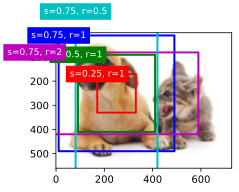

In [10]:
d2l.set_figsize()
bbox_scale=torch.tensor((w,h,w,h))
fig=d2l.plt.imshow(img)
show_bboxes(fig.axes,boxes[250,250,:,:]*bbox_scale,['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5'])

In [11]:
#计算两个锚框或边界框列表中成对的交并比
def box_iou(boxes1,boxes2):
    #定义一个计算框的面积的函数
    box_area=lambda boxes:((boxes[:,2]-boxes[:,0])*(boxes[:,3]-boxes[:,1]))
    #计算两个框的面积
    areas1=box_area(boxes1)
    areas2=box_area(boxes2)

    #这里下面三个的形状都为（boxes1数量，boxes2数量，2）
    #如果不加上None的话，就可能会出现数据个数不匹配的现象，或者只配对了相同索引的两个并没有完全的两两组队
    #这个得出每对锚框相交部分的左上角的坐标
    inter_upperlefts=torch.max(boxes1[:,None,:2],boxes2[:,:2])
    #这个得出每对锚框相交部分的右下角的坐标
    inter_lowerrights=torch.min(boxes1[:,None,2:],boxes2[:,2:])

    #如果右下角坐标减去左上角坐标中存在负数的话，就说明两个框根本不相交，将其值置为0就可以了
    inters=(inter_lowerrights-inter_upperlefts).clamp(min=0)

    #这里下面两个的形状都为（boxes1数量，boxes2数量）
    #计算相交的面积，如果不相交的话，上面已经置为0了，的出来的面积就会为0
    inter_areas=inters[:,:,0]*inters[:,:,1]
    #相并的面积为两面积相加然后减去相交的面积
    union_areas=areas1[:,None]+areas2-inter_areas

    #返回交并比，形状为(boxes1数量,boxes2数量)
    return inter_areas/union_areas

In [12]:
#将最接近的真实边界框分配给锚框
def assign_anchor_to_bbox(ground_truth,anchors,device,iou_threshold=0.5):
    #获取锚框的数量和真实框的数量
    num_anchors,num_gt_boxes=anchors.shape[0],ground_truth.shape[0]
    #位于第i行和第j列的元素x_ij是锚框i的真实边界框j的iou
    #求锚框和真实框的交并比，形状为(锚框数量，真实框数量)
    jaccard=box_iou(anchors,ground_truth)
    
    #这里就是获得一个长度为锚框数量的向量，用来记录对应的锚框被分配给的真实框
    anchors_bbox_map=torch.full((num_anchors,),-1,dtype=torch.long,device=device)
    #根据阈值决定是否分配真实边界框
    #max返回两个值，每行最大值及其所在列,dim=1就是找出每行的最大值，形状为(锚框数量，)
    max_ious,indices=torch.max(jaccard,dim=1)

    #nonzero返回的张量为n*1，其中n是max_ious中大于0.5的数量
    #anc_i保存了该行最大值大于阈值的行号
    anc_i=torch.nonzero(max_ious>=0.5).reshape(-1)
    # box_j保存了该列最大值大于阈值的列号
    box_j=indices[max_ious>=0.5]
    #将列号存放到对应的行号中,表示这一列所表示的真实框分配给这个锚框了
    anchors_bbox_map[anc_i]=box_j

    #这两个用来消除去掉了最大值的行、列
    col_discard=torch.full((num_anchors,),-1)
    row_discard=torch.full((num_gt_boxes,),-1)

    #这个for循环是每次找出iou最大的，将其更新到anchors_bbox_map中
    for _ in range(num_gt_boxes):
        #获取整个矩阵的最大值所在的位置。从第一个数开始数
        max_idx=torch.argmax(jaccard)
        #序号除以列数取余得到所在的列号
        box_idx=(max_idx%num_gt_boxes).long()
        #序号除以列数取整得到所在的行号
        anc_idx=(max_idx/num_gt_boxes).long()

        #将列号号放入对应的行号中，这一步一定会和for循环之前的赋值有重复的，但是不会影响最后的值
        anchors_bbox_map[anc_idx]=box_idx
        #将该最大值对应的行列填充成-1
        jaccard[:,box_idx]=col_discard
        jaccard[anc_idx,:]=row_discard
    #返回每个锚框对应分配到的真实框，形状为(锚框数量，)
    return anchors_bbox_map

In [13]:
#对锚框偏移量的转换
def offset_boxes(anchors,assigned_bb,eps=1e-6):
    #将锚框和真实边框的位置信息转换为中心模式表示
    c_anc=d2l.box_corner_to_center(anchors)
    c_assigned_bb=d2l.box_corner_to_center(assigned_bb)

    #这两步就是按照公式来进行计算 没什么好说的
    offset_xy=10*(c_assigned_bb[:,:2]-c_anc[:,:2])/c_anc[:,2:]
    offset_wh=5*torch.log(c_assigned_bb[:,2:]/c_anc[:,2:])


    offset=torch.cat([offset_xy,offset_wh],axis=1)

    #返回的offset形状是(锚框数量，4)
    return offset

In [14]:
#使用真实边界框labels来标记锚框
def multibox_target(anchors,labels):
    #批量大小设置为标签的数量
    batch_size,anchors=labels.shape[0],anchors.squeeze(0)
    batch_offset,batch_mask,batch_class_labels=[],[],[]
    #记录锚框的数量
    device,num_anchors=anchors.device,anchors.shape[0]
    
    #对一个批量进行遍历
    for i in range(batch_size):
        label=labels[i,:,:]
        anchors_bbox_map=assign_anchor_to_bbox(label[:,1:],anchors,device)

        #最终得到的形状为(锚框数量，4)，每一行都是分配到真实框的索引
        bbox_mask=((anchors_bbox_map>=0).float().unsqueeze(-1)).repeat(1,4)

        #将类标签和分配的边界框坐标初始化为零
        class_labels=torch.zeros(num_anchors,dtype=torch.long,device=device)
        assigned_bb=torch.zeros((num_anchors,4),dtype=torch.float,device=device)
        
        #没有分配到真实框的锚框被标记为背景框，indices_true形状为(分配到真实框的锚框个数，1)
        indices_true=torch.nonzero(anchors_bbox_map>=0)
        #获取每个锚框分配到的真实框的索引信息
        bb_idx=anchors_bbox_map[indices_true]        
        #将真实框的标签赋值给锚框的标签
        class_labels[indices_true]=label[bb_idx,0].long()+1
        #将真实框的位置信息赋值给assigned_bb
        assigned_bb[indices_true] =label[bb_idx,1:]

        #进行偏移量的转化
        offset=offset_boxes(anchors,assigned_bb)*bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)

    bbox_offset=torch.stack(batch_offset)
    bbox_mask=torch.stack(batch_mask)
    class_labels=torch.stack(batch_class_labels)

    return (bbox_offset,bbox_mask,class_labels)


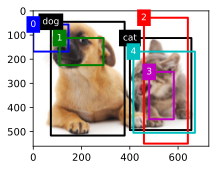

In [15]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig=d2l.plt.imshow(img)
show_bboxes(fig.axes,ground_truth[:,1:]*bbox_scale,['dog','cat'],'k')
show_bboxes(fig.axes,anchors*bbox_scale,['0','1','2','3','4'])

In [16]:
labels=multibox_target(anchors.unsqueeze(dim=0),ground_truth.unsqueeze(dim=0))


In [17]:
#返回的第三个元素包含的是标记的输入锚框的类别
labels[2]

tensor([[0, 1, 2, 0, 2]])

In [18]:
#返回的第二个元素是掩码，形状为(批量大小，锚框数量*4)
labels[1]

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

In [19]:
#返回的第一个元素是包含了每个锚框标记的四个偏移值
labels[0]

tensor([[-0.00e+00, -0.00e+00,       nan,       nan,  1.40e+00,  1.00e+01,
          2.59e+00,  7.18e+00, -1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00,
         -0.00e+00, -0.00e+00,       nan,       nan, -5.71e-01, -1.00e+00,
         -8.94e-07,  6.26e-01]])

In [20]:
#根据带有预测偏移量的锚框来预测边界框
def offset_inverse(anchors,offset_preds):
    anc=d2l.box_corner_to_center(anchors)
    #分别根据偏移量来还原该锚框对应的真实框来作为预测框
    pred_bbox_xy=(offset_preds[:,:2]*anc[:,:2]/10)+anc[:,:2]
    pred_bbox_wh=torch.exp(offset_preds[:,2:]/5)*anc[:,2:]

    pred_bbox=torch.cat((pred_bbox_xy,pred_bbox_wh),axis=1)
    predicted_bbox=d2l.box_corner_to_center(pred_bbox)

    return predicted_bbox


In [26]:
#对预测边界框的置信度进行排序
def nms(boxes,scores,iou_threshold):
    B=torch.argsort(scores,dim=-1,descending=True)
    keep=[]

    while B.numel()>0:
        i=B[0]
        keep.append(i)

        if B.numel()==1: break

        iou=box_iou(boxes[i,:].reshape(-1,4),boxes[B[1:],:].reshape(-1,4).reshape(-1))
        inds=torch.nonzero(iou<=iou_threshold).reshape(-1)

    return torch.tensor(keep,device=boxes.device)

In [28]:
#@save
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """使用非极大值抑制来预测边界框"""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)

        # 找到所有的non_keep索引，并将类设置为背景
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # pos_threshold是一个用于非背景预测的阈值
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

In [29]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                      [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4,  # 背景的预测概率
                      [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
                      [0.1, 0.2, 0.3, 0.9]])  # 猫的预测概率

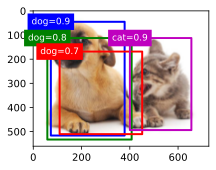

In [30]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

In [31]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
output

IndexError: too many indices for tensor of dimension 1